# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | LEMARCHANT HUGO - AP85480 • TAN ELODIE - TANE25619607 •  JACQUES-SYLVAIN LECOINTRE LECJ19128301| 
|-----------------------|--------------------------------------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine                              |
| Session               | AUTOMNE 2018                                                                         |
| Groupe                | C                                                                                    |
| Numéro du laboratoire | 1                                                                                    |
| Professeur            | Prof. Hervé Lombaert                                                                 |
| Chargé de laboratoire | Pierre-Luc Delisle                                                                   |
| Date                  | 2018/09/27                                                                           |

In [60]:
# -*- coding:utf-8 -*-
import numpy as np
import cv2
import core
import matplotlib.pyplot as plt
import sys
import os, random
import math
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
import scipy.ndimage as nd
import csv
import pandas as pd
import graphviz

ImportError: No module named 'graphviz'

In [3]:
# Hugo
pathHugo = "E:\\DocsPerso\\DocsBoulot\\ETS-MTL\\GTI770-02-SystIntel&MachineLearning\\data\\data\\images\\"
# JS
pathJS= '/Users/jslecointre/Documents/DataScience/courses/MACHINE_LEARNING/TP/data/images/'
pathElodie = '/Users/raen/Documents/UTC/ETS/GTI770/GTI770-Data/images/'
exts = ".jpg"
nb_img = "107159"

In [4]:
# choose your correct path here
path=pathElodie

In [5]:
imgFile = cv2.imread(path + nb_img + exts)
GP=core.GalaxyProcessor(path)

### Feature #1 ratio_aspect

Mettre fonction ratio_aspect

Fonction test_ratio_aspect

### Feature #2 CCV

Fonction CCV

im_cropped.shape

### Feature #3 Circularity

Fonction calculateCircularity


image = plt.imread(path)
plt.imshow(image)
plt.show()

calculateCircularity(image)

## Fonction calcul des primitives

In [6]:
def calculateAttributes(n):
    """Function to calculate the attributes of the galaxy images.

    Args:
        n: number of images for which we want to calculate the attributes.

    Returns:
        Two lists : 
            - The feature vectors for each image : ratio, circularity and CCV.
            - The associated label to each feature vector.

    """
    df = pd.read_csv('galaxy/galaxy_label_data_set.csv', delimiter = ',')
    df = df.groupby('class').apply(lambda x: x.sample(n//2)).reset_index(drop=True)
    return [GP.get_features(x) for x in df.id.values], df['class'].values

In [8]:
N=100
attributes=calculateAttributes(N)
features=np.array(attributes[0])

In [9]:
print(attributes)

([array([9.71326151e-01, 3.48124996e-01, 0.00000000e+00, 7.56610000e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.42000000e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
    

In [39]:
labels=np.array(attributes[1])
label_colors= [ 'red' if y=='smooth' else 'blue' for  y in labels]
label_values= [ 1 if y=='smooth' else 2 for  y in labels]

# extract each feature separa
circularity = features[:,1:2].T[0]
aspect_ratio= features[:,0:1].T[0]
ccv = features[:,2:]


array([[9.71326151e-01, 3.48124996e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.43790858e-01, 2.33752395e-01, 7.53640000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.43414675e-01, 6.47640747e-01, 5.03720000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.85632997e-01, 5.47653832e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.28645832e+00, 4.73111893e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.18863235e-01, 4.50868768e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Analyse des primitives
### Circularité

Afficher fonction Circularité

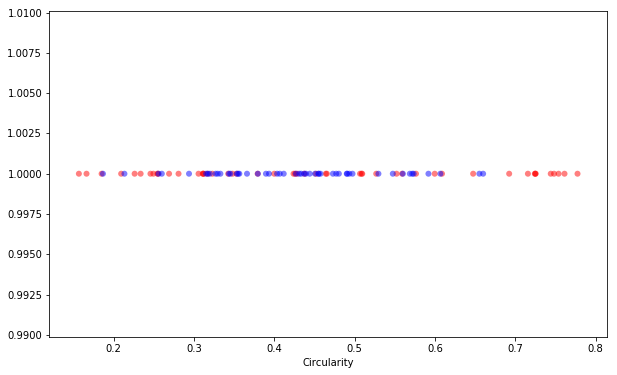

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(circularity, np.ones(N),c=label_colors,marker='o',alpha=0.5, edgecolors='none')
plt.xlabel('Circularity')
plt.show()

### RatioAspect

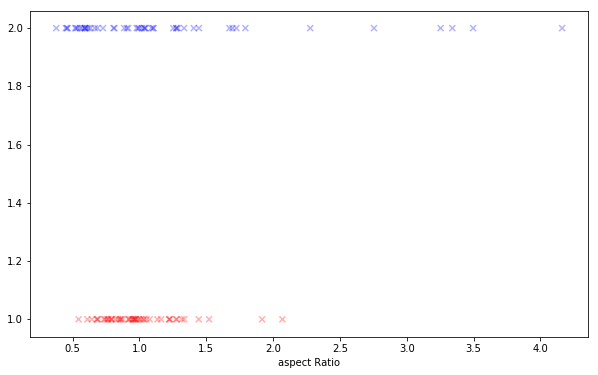

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(aspect_ratio,label_values,c=label_colors,marker='x',alpha=0.3, edgecolors='none')
plt.xlabel('aspect Ratio')
plt.show()

### Ratio-aspect vs Circularity

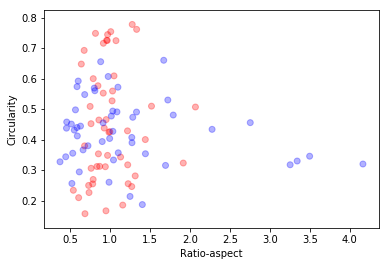

In [50]:
plt.scatter(aspect_ratio,circularity,c=label_colors,alpha=0.3)
plt.xlabel('Ratio-aspect')
plt.ylabel('Circularity')
plt.show()

### CCV - TSNE

example of CCV feature vector computation

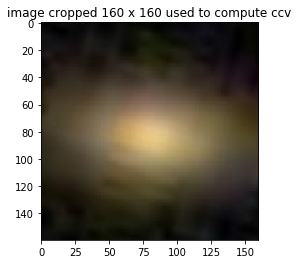

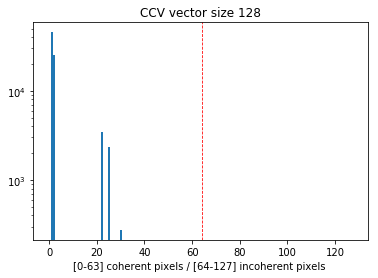

In [67]:
path=pathJS
GP=core.GalaxyProcessor(path)
filename=random.choice(os.listdir(path))
coherence_threshold = 160**2*0.01
nb_colors = 64
img = cv2.imread('{0}{1}'.format(path,filename))

X = [x for x in range(nb_colors * 2)]
Y = GP.get_ccv(img, coherence_threshold, nb_colors)

cropped=GP.crop_image(img, 212-80, 212+80)
im = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.title('image cropped 160 x 160 used to compute ccv')
plt.show()

plt.bar(X, list(Y[0])+list(Y[1]), align='center')
plt.title('CCV vector size {0}'.format(nb_colors*2))
plt.axvline(x=nb_colors,color='r',linestyle='dashed',linewidth=0.8)
plt.yscale('log')
plt.xlabel("[0-63] coherent pixels / [64-127] incoherent pixels ")
plt.show()

la caracteristique CCV etant un vecteur de taille 128 , il est impossible de visualiser en 2D la repartition des valeurs selon les classes
le TSNE est utilise pour cela

In [51]:
import numpy as np
from sklearn.manifold import TSNE
ccv = features[:,2:]
X_embedded = TSNE(n_components=2).fit_transform(ccv)

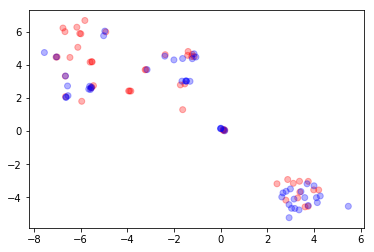

In [52]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=label_colors,alpha=0.3,)
plt.show()

## Arbre de décision

In [53]:
X = attributes[0]
Y = attributes[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

clf = tree.DecisionTreeClassifier( max_depth = 10)
clf = clf.fit(X_train, Y_train)

In [54]:
clf.score(X_test, Y_test)

0.6

### Cross-validation

In [59]:
scores = cross_val_score(clf, X, Y, cv=5)

cross_validation = sum(scores)/5
print(cross_validation)

0.64


## Questions

### Question 1 : Introduction et revue de la littérature

Après lecture des différents papiers de recherche, nous nous sommes concentré sur Morphological classification of galaxies into spirals and non-spirals (D. Dhami). En effet, ses travaux répondent parfaitement à la problématique qui nous est posée, c'est à dire la différenciation entre les galaxies rondes et celles en forme de spirale. Plusieurs caractéristiques de galaxies sont étudiées dans sa recherche, et elle explicite aussi celles qui fonctionnent le mieux. 


### Question 2

Nous avons donc choisi d'étudier :

- La circularité
- CCV
- Ratio-aspect

Pour ce qui est de la circularité, nous avons effectué plusieurs recherches sur comment la calculer. La plupart des sites mentionnent la formule $ C = 4 * \pi * area / P^2 $.

Le choix de ces features s'est fait à partir de la documentatioin fournie et des papiers de recherche. Nous avons choisi une caractéristique "humainement parlante" qu'est la circularité, une autre simplement implémentable qu'est le ratio de l'aspect qui semble relativement discriminante. Enfin dans un des papiers de recherche, la CCV semblait être la caractéristique la plus discriminante.

### Question 3



### Question 4
Plus $max-depth$ est petit, plus la valeur du score est petite. En effet, il y aura moins de primitives qui vont permettre de choisir la bonne classification. Cependant, lorsque $max-depth$ est trop grand, on aura fait un over-fitting. En effet, la profondeur de l'arbre étant très grande, l'algorithme apprendra beaucoup mieux des données d'apprentissage. Cependant, sur les données de test, l'algorithme donnera de moins bonnes valeurs.

### Question 5

Nous aurions pu prendre en compte la couleur du noyau de la galaxie qui est un indicateur de l'âge de la galaxie. Hors l'âge influence la forme de la galaxie. En effet, les galaxies les plus âges ont perdu de la vitesse de rotation ce qui donne la forme caractéristique des galaxies dites "smooth". [5]

### Conclusion

### Bibliographie
[1] http://scikit-learn.org/stable/modules/cross_validation.html  
[2] http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  
[3] Dhami, Devendra. (2015). Morphological classification of galaxies into spirals and non-spirals.   10.13140/RG.2.2.22792.62727.   
[4] https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html  
[5] https://fr.wikipedia.org/wiki/Galaxie_spirale 